<a href="https://colab.research.google.com/github/tejash0901/final_mini/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to

In [2]:
import numpy as np
from Bio import SeqIO
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
classesDict = {0: "MERS", 1: "SARS"}

attributes_list = []
classes_list = []
attrsSize = 0

In [4]:
for key in classesDict:
    fasta_file = "/content/drive/MyDrive/data/sequences" + classesDict[key] + ".fasta"
    fasta_sequences = SeqIO.parse(open(fasta_file), 'fasta')

    for fasta in fasta_sequences:
        attributes_list.append(str(fasta.seq))
        classes_list.append(key)

    class_size = len(classes_list) - attrsSize
    print("class", classesDict[key], "size:", class_size)
    attrsSize = len(attributes_list)

attributes = np.array(attributes_list)
classes = np.array(classes_list)

print("total attributes size before oversampling:", attributes.shape[0])
print("total classes size before oversampling:", classes.shape[0])

class MERS size: 1453
class SARS size: 674
total attributes size before oversampling: 2127
total classes size before oversampling: 2127


In [6]:
attributes = attributes.reshape(-1, 1)

oversampling_classes = {1: 1500}
sampler = SMOTEN(sampling_strategy=oversampling_classes, random_state=0)
X_res, y_res = sampler.fit_resample(attributes, classes)
maxSequence = 6000
X_resBinarized = np.zeros((len(X_res), maxSequence, 1), dtype=np.uint8)
for i, sequence in enumerate(X_res):
    sequenceStr = sequence[0]
    sequenceBinarizedStr = ""
    index = 0
    for char in sequenceStr:
        if index < maxSequence:
            if char == 'a':
                sequenceBinarizedStr += "1"
            elif char == 'c':
                sequenceBinarizedStr += "2"
            elif char == 'g':
                sequenceBinarizedStr += "3"
            elif char == 't':
                sequenceBinarizedStr += "4"
            else:
                sequenceBinarizedStr += "0"
        index += 1

    if len(sequenceStr) < maxSequence:
        sequenceLength = len(sequenceStr)
        while sequenceLength < maxSequence:
            sequenceBinarizedStr += "0"
            sequenceLength += 1

    sequenceBinarized = np.array(list(sequenceBinarizedStr), dtype=np.uint8)
    X_resBinarized[i] = sequenceBinarized.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X_resBinarized, y_res, test_size=0.3, random_state=4, stratify=y_res)

print("x_train size: ", x_train.shape[0])
print("y_train size: ", y_train.shape[0])
print("x_test size: ", x_test.shape[0])
print("y_test size: ", y_test.shape[0])


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1453)
  warnings.warn(


x_train size:  2067
y_train size:  2067
x_test size:  886
y_test size:  886


In [7]:
batch_size = 32
num_classes = 2
epochs = 6

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
y_test1 = np.argmax(y_test, axis=1)
y_train1 = np.argmax(y_train, axis=1)

In [9]:
input_shape = (maxSequence, 1)
num_classes = 2

inputs = keras.Input(shape=input_shape)

# Initial convolutions
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)

# Residual blocks with recurrent connections
for _ in range(4):
    res = x
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv1D(64, kernel_size=3, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([res, x])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

# LSTM layer to capture temporal information
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=False)(x)

# Fully-connected layers
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='recurrent_residual_cnn')
model.summary()

Model: "recurrent_residual_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 64)     256         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 6000, 64)     12352       ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 6000, 64)    256         ['conv1d_1[0][0]']               
 alization)                                                                  

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/6
65/65 [==============================] - 257s 4s/step - loss: 0.6403 - accuracy: 0.6904 - val_loss: 0.6849 - val_accuracy: 0.4921
Epoch 2/6
65/65 [==============================] - 266s 4s/step - loss: 0.6143 - accuracy: 0.6759 - val_loss: 0.6795 - val_accuracy: 0.4921
Epoch 3/6
65/65 [==============================] - 243s 4s/step - loss: 0.5495 - accuracy: 0.7131 - val_loss: 0.6445 - val_accuracy: 0.7449
Epoch 4/6
65/65 [==============================] - 264s 4s/step - loss: 0.5374 - accuracy: 0.7107 - val_loss: 0.5846 - val_accuracy: 0.7449
Epoch 5/6
65/65 [==============================] - 266s 4s/step - loss: 0.5195 - accuracy: 0.7213 - val_loss: 0.5588 - val_accuracy: 0.7573
Epoch 6/6
65/65 [==============================] - 263s 4s/step - loss: 0.5091 - accuracy: 0.7247 - val_loss: 0.5012 - val_accuracy: 0.7573


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5012131929397583
Test accuracy: 0.7573363184928894


In [13]:
y_predicted = model.predict(x_test)
print("Prediction: ", y_predicted)

28/28 [==============================] - 22s 705ms/step
Prediction:  [[0.9843242  0.01567574]
 [0.21276918 0.7872308 ]
 [0.21276918 0.7872308 ]
 ...
 [0.984245   0.01575499]
 [0.21276914 0.7872309 ]
 [0.21276918 0.7872308 ]]


In [14]:
y_pred_labels = np.argmax(y_predicted, axis=1)

In [15]:
y_pred_labels

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [16]:
import seaborn as sns

Confusion matrix
[[225 211]
 [  4 446]]

Classification report
              precision    recall  f1-score   support

        Mers       0.98      0.52      0.68       436
        Sars       0.68      0.99      0.81       450

    accuracy                           0.76       886
   macro avg       0.83      0.75      0.74       886
weighted avg       0.83      0.76      0.74       886



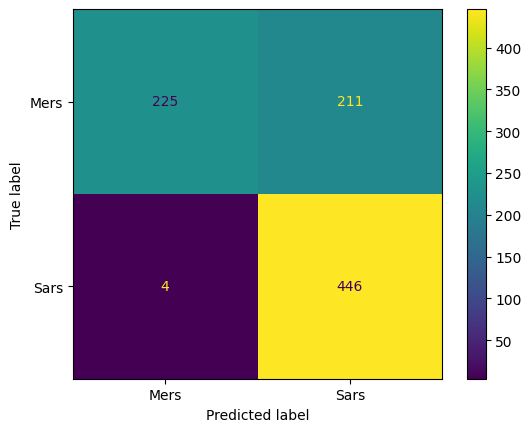

In [17]:
from sklearn import metrics

print("Confusion matrix")
confusion_matrix = metrics.confusion_matrix(y_true=y_test1, y_pred=y_pred_labels)
print(confusion_matrix)
target_names = ['Mers', 'Sars']
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=target_names)
disp.plot()

print()
print("Classification report")
report = metrics.classification_report(y_test1, y_pred_labels, target_names=target_names)
print(report)

In [18]:
model.save('fmodel.h5')